# Interpreting CNNs & Adversarial Robustness

### The purpose of this notebook is to show what  "adversarial examples" are, and their relationships with convolutional neural networks 

### We will see how vulnerable state of the art CNN's are to data variance, and how to mitigate that vulnerability. 


In [3]:
import os
import src
import src.imaging as imaging
from matplotlib import pyplot as plt
import time
%load_ext autoreload
%autoreload 2

### The "imaging" module is some code I've written that lets us do things regarding interpetability. 

In [4]:
first = imaging.Model_Interpreter(verbose = False)

In [5]:
# Loads the CIFAR10 test set, let's make it iterable with the batch size of 1
# The loader draws at random
first.load_data(dataset='cifar10')

# Uncomment below for a full test... After which, you will have to get the data again.
# m1 = first.load_model('TRAINED_MODELS/test1.pth')
# acc = first.validation_test(m1)
# first.load_data(dataset='cifar10')

first.data = iter(first.data)

Files already downloaded and verified


### The input to a CNN is an image. The task I am interested in is image classification. Below is an image! 
### To the CNN, images have absolutely no semantic meaning. They're just numbers.

In [6]:
tns,label = next(first.data)
tns

tensor([[[[0.1882, 0.2510, 0.4588,  ..., 0.1098, 0.1059, 0.1020],
          [0.3333, 0.2196, 0.1922,  ..., 0.1176, 0.1098, 0.1059],
          [0.4196, 0.4275, 0.3255,  ..., 0.1176, 0.1137, 0.1059],
          ...,
          [0.1059, 0.1059, 0.1137,  ..., 0.1176, 0.1137, 0.1137],
          [0.1059, 0.1059, 0.1137,  ..., 0.1137, 0.1098, 0.1098],
          [0.1020, 0.1020, 0.1098,  ..., 0.1098, 0.1059, 0.1059]],

         [[0.2667, 0.3176, 0.5216,  ..., 0.2157, 0.2118, 0.2078],
          [0.4196, 0.2902, 0.2588,  ..., 0.2235, 0.2157, 0.2118],
          [0.5098, 0.5059, 0.3922,  ..., 0.2235, 0.2196, 0.2118],
          ...,
          [0.2118, 0.2118, 0.2196,  ..., 0.2314, 0.2275, 0.2275],
          [0.2118, 0.2118, 0.2196,  ..., 0.2275, 0.2235, 0.2235],
          [0.2078, 0.2078, 0.2157,  ..., 0.2235, 0.2196, 0.2196]],

         [[0.3608, 0.3961, 0.5843,  ..., 0.3333, 0.3294, 0.3255],
          [0.5059, 0.3765, 0.3412,  ..., 0.3412, 0.3373, 0.3294],
          [0.5922, 0.5961, 0.4941,  ..., 0

In [7]:
# First, a quick sidebar about labels... There are 10
cifar_labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
# What's the label on our current image?
label

tensor([0])

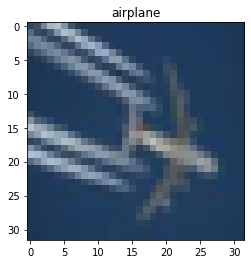

In [8]:
# Let's show this one as an image, pass only the tensor, not the class
image = first.tensor2image(tns[0])

plt.title(cifar_labels[int(label)])
plt.imshow(image)

### More Images from CIFAR-10. This is a very commonly used dataset in the ML community and contains small, $3\times32\times32$ images which are good for testing.

In [9]:
#Function to show several images
def show_panel(data):
    fig = plt.figure(figsize = (16,16))
    ax = []
    for i in range(len(data)):
        if len(data[i])==2:
            tns,label = data[i]
            title = cifar_labels[int(label)]
        else:
            tns,label,title = data[i]
        image = first.tensor2image(tns[0])
        ax.append(fig.add_subplot(1,len(data), i+1))
        ax[-1].set_title(title) 
        ax[-1].set_yticklabels([])
        ax[-1].set_xticklabels([])
        plt.imshow(image)

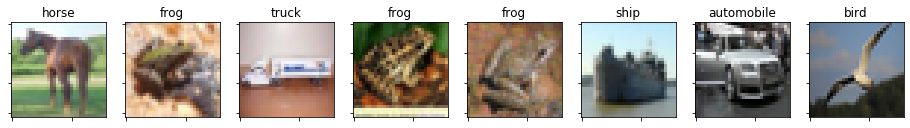

In [10]:
#Let's show 8 
#Get the data, then call the function
imgs = []
for i in range(8):
    imgs.append(next(first.data))

show_panel(imgs)

### Now let's look at a state of the art ResNet model, which was trained on this data.

In [12]:
# This model is a dense ResNet, trained on the CIFAR-10 dataset, without any attention paid to robustness.
m1 = first.load_model('models/test1.pth')

In [13]:
# weigh_prune is a script I wrote to do the two things stated in the title
import weigh_prune as wp
wp.weigh(m1,name='Model 1')

Weighing Model 1
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14  

NameError: name 'pt' is not defined

### Running inference with that model

===Class Predictions===
airplane: 7.26
automobile: -2.75
bird: -0.54
cat: -2.57
deer: -3.34
dog: -1.02
frog: -3.62
horse: 5.8
ship: -2.82
truck: 3.68
Predicted Class: airplane
Time: 0.1449 seconds


1

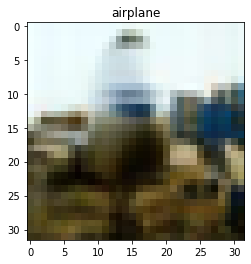

In [14]:
tns, label = next(first.data)

image = first.tensor2image(tns[0])
plt.title(cifar_labels[int(label)])
plt.imshow(image)


# Model Predictions
first.verbose = True
first.predict(m1,tns,label)

# Adversarial Attacks

### Adding variance at training time $\longrightarrow$ Increased resistance to variance at test time

### In general, an 'attack' takes the following structure:

### Let $\Delta = \{ \delta:||\delta|| \leq \epsilon \}$ be the $\ell_{\infty}$ ball,
### The projection is $P_{\Delta}(\delta)= Clip(\delta, [-\epsilon,\epsilon])$
###  With $\delta = \epsilon \times \nabla_{\delta}Loss(x+\delta,y;\theta)$

### In short, we want to take $n$ 'steps' of maximum size $\epsilon$ in the direction of the gradient. This gives us an altered, or 'attacked' image. We will look at two methods for doing so:

<img src="other/3d_grad.png">

### - Fast Gradient Sign Method (FGSM)

### This is the first example of an adversarial attack, it is a 'one-shot' attack which aims to deprecate the confidence of the model by taking one step in the direction of the loss, for each of the color channels. That is, the R, G, or B value of a given pixel may change by up to $\epsilon$/255

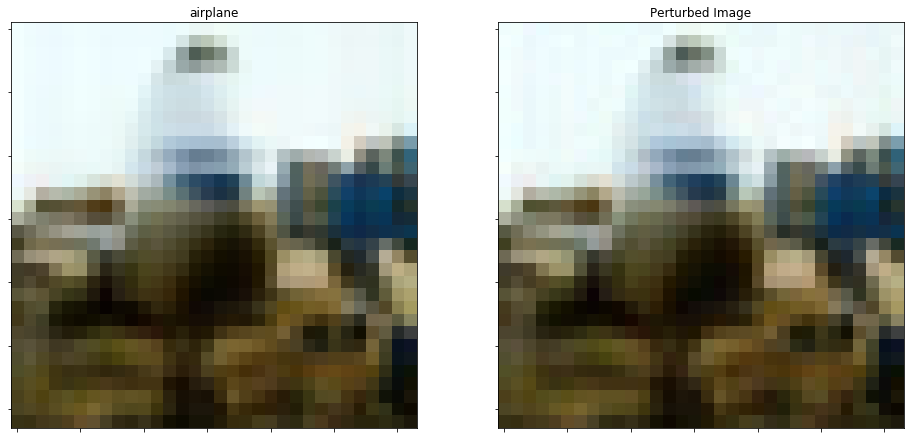

In [15]:
attacked_tns = first.fgsm(m1,tns,label, attack_radius = 2)
display = [[tns,label],[attacked_tns,label,'Perturbed Image']]
show_panel(display)

### The model fails when we introduce an imperceptible amount of noise to the test image

In [16]:
first.predict(m1,attacked_tns,label)

===Class Predictions===
airplane: -0.87
automobile: -4.44
bird: -0.68
cat: -3.39
deer: -1.89
dog: 4.47
frog: -4.7
horse: 12.53
ship: -2.89
truck: 1.94
Predicted Class: horse
Time: 0.1233 seconds


0

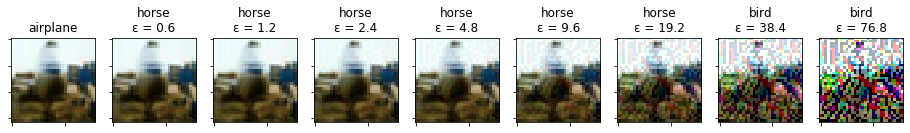

In [17]:
# tns, label = next(first.data)
def perturbed_display(model,tensor,lab, val = 0.75, atk = 'fgsm', steps = 5):
    disp = [[tensor,lab]]
    for i in range(8):
        at_im = first.pgd(model,tns,lab,attack_radius = val, steps = steps) if atk=='pgd' else first.fgsm(model,tns,lab, attack_radius = val)
        prediction = first.predict(model,at_im,lab, ret = 'Integer')
        disp.append([at_im,prediction,"{}\n\u03B5 = {}".format(cifar_labels[int(prediction)],val)])
        val *= 2
    show_panel(disp)

first.verbose = False
perturbed_display(m1,tns,label,val = 0.6)

### The model above has been trained on the CIFAR-10 training set. It is believed that adversarial examples are features of such datasets, not bugs. 

### The modern school of thought is to introduce variance to the training set. There is no universal amount or method of adding variance, and can be adapted to use cases. 

### Let's see a model trained on images with up to 7 steps of PGD, with $\epsilon = \frac{4}{255}$

### This model is more resistant to FGSM attacks at test time


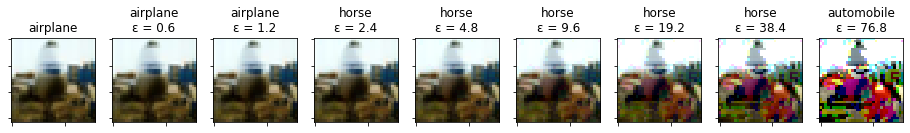

In [19]:
m2 = first.load_model('models/test8.pth')

perturbed_display(m2,tns,label,val = 0.6) 


# Projected Gradient Descent (PGD)
### PGD consists of $n$ steps of size $\epsilon$ in the direction of the gradient. 

### Let's see it on the first (vulnerable) model

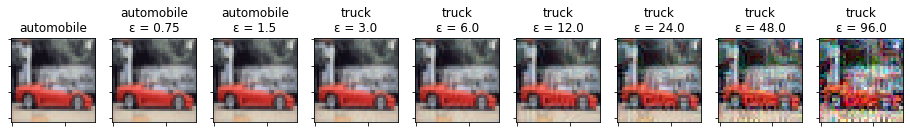

In [25]:
# tns, label = next(first.data)

perturbed_display(m1,tns,label,atk='pgd', steps=15)

### And now a model trained on noisy data: up to 7 steps of PGD, each with $\epsilon=\frac{4}{255}$. 

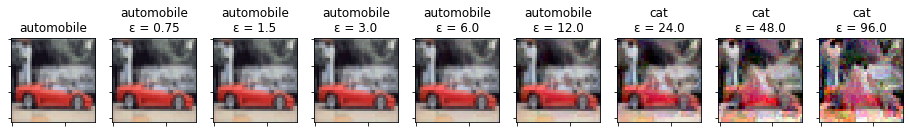

In [26]:
perturbed_display(m2,tns,label,atk='pgd', steps=15)

### A new model, trained using FGSM with $\epsilon=\frac{3}{255}$

In [22]:
# tns, label = next(first.data)

# m3 = first.load_model('TRAINED_MODELS/test2.pth')
# perturbed_display(m3,tns,label,atk='pgd', steps=15)
# perturbed_display(m3,tns,label)

### A new model: with 10% the nonzero parameters as the three models above, trained on benign data

In [23]:
# m4 = first.load_model('models/test3.pth')

# perturbed_display(m4,tns,label,atk='pgd', steps=15)
# perturbed_display(m4,tns,label)

### A new model: trained with FGSM $\epsilon = \frac{3}{255}$, and has 10% nonszero parameters like the previous model

In [24]:
# m5 = first.load_model('models/test4.pth')

# perturbed_display(m5,tns,label,atk='pgd', steps=15)
# perturbed_display(m5,tns,label)

### A new model: Trained with PGD with up to 12 steps, and $\epsilon=\frac{16}{255}$

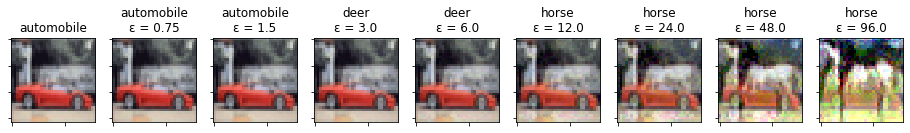

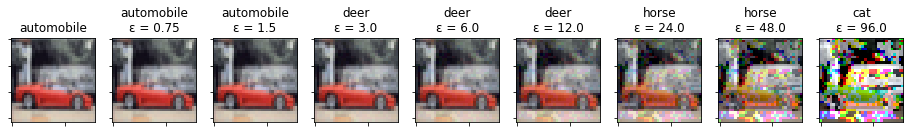

In [27]:
m6 = first.load_model('models/mod1.pth')

perturbed_display(m6,tns,label,atk='pgd', steps=15)
perturbed_display(m6,tns,label)